In [1]:
loaded_modules=0

In [2]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
import wandb

In [3]:
results_dir_local=os.getcwd()

In [4]:
config_trial = None
physics_trial = None
store_trial = None
net_trial = None


# truths = np.array([
#     [ 0,     -9 , 2.11 , 560,   25.0,39.0,4.05,500.0,80.0,280.0,1.2,0.58,0.5,0.18,9.0,-2.8],
#     [ 0.5,  -9.5 ,   1  , 560,   25.0,39.0,4.05,500.0,80.0,280.0,1.2,0.58,0.5,0.18,9.0,-2.8],
#     [ -0.5,  -10 ,   3  , 560,     25.0,39.0,4.05,500.0,80.0,280.0,1.2,0.58,0.5,0.18,9.0,-2.8],

# ])

colors = [
    'r',
    '#FFA500',
    'y',
    'g',
    'b',
    'k'
]


in_archive = True if len(results_dir_local.split("/archive/")) != 1 else False
if config_trial == None:
    config_path = results_dir_local+"/config_variables.pickle"
else:
    config_path = results_dir_local.split("/archive/")[0]+"/archive/trial__"+str(physics_trial)+"/config_variables.pickle"
if physics_trial == None:
    physics_path = results_dir_local+"/physics_variables.pickle"
else:
    physics_path = results_dir_local.split("/archive/")[0]+"/archive/trial__"+str(physics_trial)+"/physics_variables.pickle"
if store_trial == None:
    store_path = results_dir_local+"/sim_output/store" if not in_archive else results_dir_local+"/store"
else:
    store_path = results_dir_local.split("/archive/")[0]+"/archive/trial__"+str(store_trial)+"/store"
if net_trial == None:
    net_path = results_dir_local+"/train_output/net" if not in_archive else results_dir_local+"/net"
else:
    net_path = results_dir_local.split("/archive/")[0]+"/archive/trial__"+str(net_trial)+"/net"

In [5]:
if loaded_modules:
    importlib.reload(network)
    importlib.reload(ALP_sim)
    importlib.reload(alp_swyft_simulator)
    importlib.reload(param_func)
    
sys.path.append(results_dir_local)
import ALP_quick_sim
ALP_sim = ALP_quick_sim.ALP_sim
import alp_swyft_simulator 
ALP_SWYFT_Simulator = alp_swyft_simulator.ALP_SWYFT_Simulator
sys.path.append(physics_path)
import param_function as param_func
param_function = param_func.param_function
sys.path.append(net_path)
import network 
Network = network.Network
loaded_modules=1   

In [6]:
with open(physics_path, 'rb') as file:
    config_objects = pickle.load(file)
for key in config_objects.keys():
    locals()[key] = config_objects[key]
with open(config_path, 'rb') as file:
    config_objects = pickle.load(file)
for key in config_objects.keys():
    locals()[key] = config_objects[key]
results_dir = results_dir_local

In [7]:
sim = ALP_SWYFT_Simulator(A, bounds)

In [12]:
observations = []
for tru in truths:
    sim.A.configure_model(ALP_seed=0)
    obs_exp=sim.generate_exp(tru)
    obs_data = sim.generate_data(obs_exp,tru)
    observations.append(swyft.Sample(data=obs_data, exp=obs_exp, params=tru))
sim.A.configure_model(ALP_seed=None)

In [8]:
store = swyft.ZarrStore(store_path + "/" + store_name)
samples = store.get_sample_store()

In [9]:
len(store)

100000

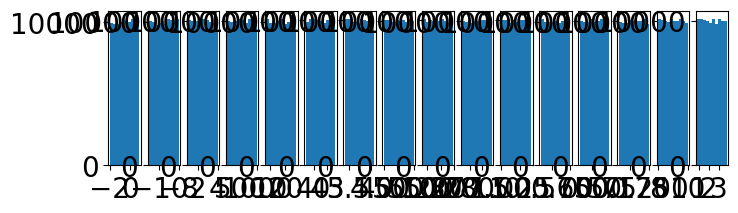

In [10]:
plt.figure(figsize=(8,2))
for i in range(len(bounds)):
    plt.subplot(1,len(samples['params'][i]),i+1)
    plt.hist(samples['params'][:,i])

In [11]:
len(samples['params'][0])

16

/home/gert/fox_hpc/ALPs_with_SWYFT/cluster_runs/analysis_results/test_inference/ALP_quick_sim.py:446: UserWarning: The number of model parameters, log-indicators, null-hypothesis parameters, parameter names and parameter units are not equal
  warnings.warn("The number of model parameters, log-indicators, null-hypothesis parameters, parameter names and parameter units are not equal")


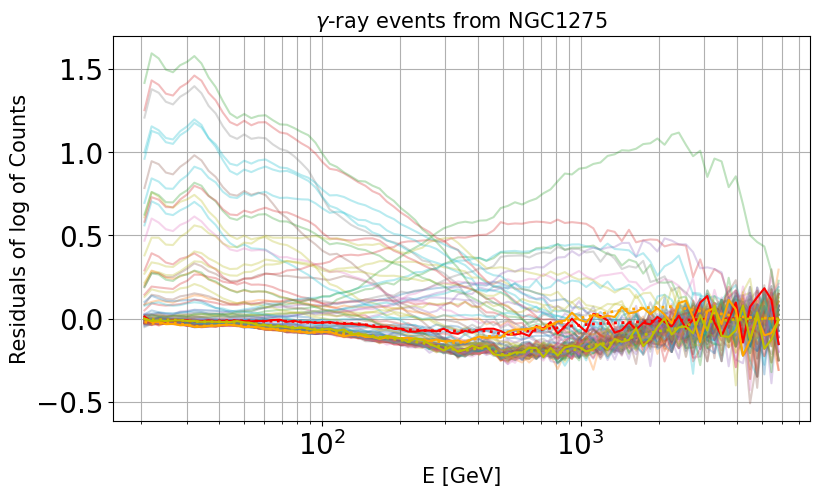

In [13]:
A.configure_plot(xmin=None, xmax=None, ymin=None,ymax=None,legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.7)
    
for i,obs in enumerate(observations):
    A.configure_model(params=obs['params'])
    A.import_counts(obs=obs['data'],exp=obs['exp'])
    shade = i/(len(observations)+1)
    A.compute_case(new_fig=0,new_counts=0,color='k',color_obs=colors[i],linestyle_obs="-",label_exp=0,label_obs=0,
                   errorbands=0, errors=0, plot_exp=0)
    A.compute_case(new_fig=0,new_counts=0,color=colors[i],color_obs=colors[i],linestyle=":",label_exp=0,label_obs=0,
                        errorbands=0, errors=0, plot_obs=0) 

In [16]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
new_net = Network(nbins=A.nbins, marginals=POI_indices, param_names=A.param_names)
new_net.load_state_dict(torch.load(net_path+'/trained_network.pt'))

<All keys matched successfully>

In [41]:
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64, #logger=wandb_logger, # min_epochs =25,
    callbacks = [lr_monitor], log_every_n_steps=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 0it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 0it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 0it [00:00, ?it/s]

<Figure size 1000x200 with 0 Axes>

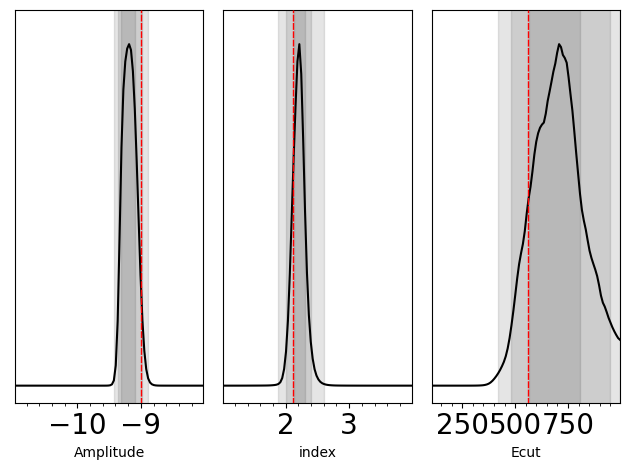

<Figure size 1000x200 with 0 Axes>

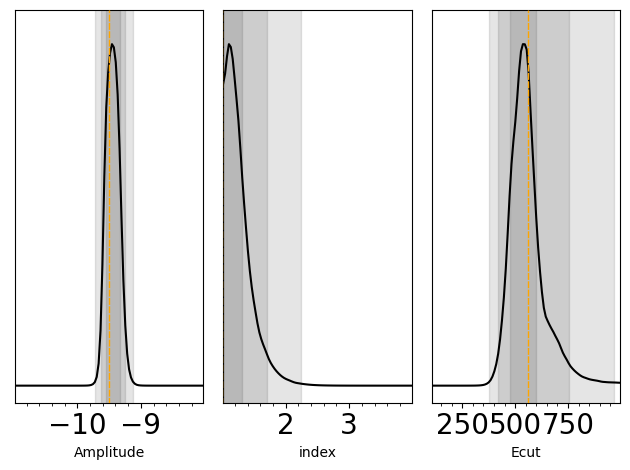

<Figure size 1000x200 with 0 Axes>

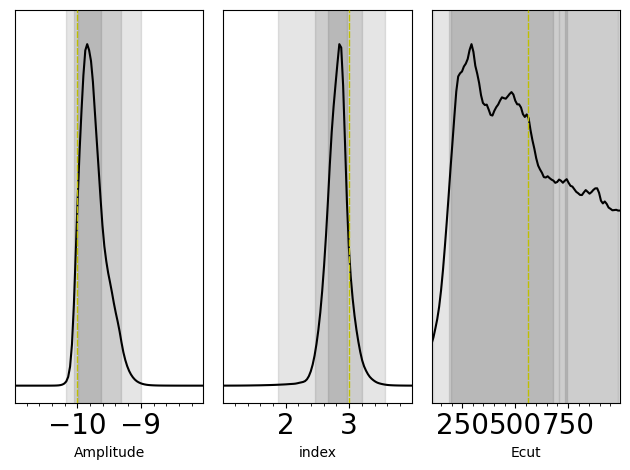

In [58]:
for j in range(len(truths)):
    plt.figure(figsize=(10,2))
    logratios = trainer.infer(
                            new_net,
                            observations[j],
                            prior_samples
                            )
    #logratios.parnames=np.expand_dims(np.array(A.param_names)[POI_indices], axis=1)
    
    # swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})
    swyft.plot_posterior(logratios, 
                         np.array(A.param_names)[POI_indices], 
                         truth={A.param_names[i]:truths[j][i] for i in POI_indices}, 
                         color_truth=colors[j]
                        )